# 4. Business Insights & Recommendations

**Project:** Intelligent Blood Supply Management

**Team:** IDGAF

---

## Executive Summary
This notebook consolidates findings from demand forecasting and donor segmentation to provide actionable business recommendations for blood bank inventory optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load all data
DATA_PATH = '../data/'

demand_df = pd.read_csv(DATA_PATH + 'demand_daily.csv', parse_dates=['date'])
supply_df = pd.read_csv(DATA_PATH + 'supply_inventory.csv', parse_dates=['date'])
donor_df = pd.read_csv(DATA_PATH + 'donor_registry.csv')
rfm_df = pd.read_csv(DATA_PATH + 'rfm_dataset.csv')

# Load segments if available
try:
    segments_df = pd.read_csv(DATA_PATH + 'donor_segments.csv')
    HAS_SEGMENTS = True
except:
    HAS_SEGMENTS = False
    
# Load forecasting results if available
try:
    forecast_results = pd.read_csv(DATA_PATH + 'forecasting_results.csv', index_col=0)
    HAS_FORECAST = True
except:
    HAS_FORECAST = False

print("Data loaded successfully!")

Data loaded successfully!


---
## 4.1 Problem Context & Impact

In [2]:
print("="*70)
print("THE BLOOD SUPPLY CHALLENGE")
print("="*70)

print("""
PROBLEM:
Blood banks face a critical dual challenge:
  1. SHORTAGE: Unpredictable demand + variable donor availability = potential loss of life
  2. WASTAGE: Perishable components (especially platelets: 5-day shelf life) = resource waste

STATISTICS (NBCUS 2019):
  - 13+ million donors present annually in the US
  - 10.8 million RBC units transfused to 4.2 million recipients
  - Wastage rates: 7-15% depending on component and facility
  - Platelets have highest wastage due to 5-day expiry

OUR SOLUTION:
  - Demand Forecasting: Predict short/medium-term blood needs
  - Donor Segmentation: Target right donors at right time
  - Inventory Optimization: Balance supply with predicted demand
""")

THE BLOOD SUPPLY CHALLENGE

PROBLEM:
Blood banks face a critical dual challenge:
  1. SHORTAGE: Unpredictable demand + variable donor availability = potential loss of life
  2. WASTAGE: Perishable components (especially platelets: 5-day shelf life) = resource waste

STATISTICS (NBCUS 2019):
  - 13+ million donors present annually in the US
  - 10.8 million RBC units transfused to 4.2 million recipients
  - Wastage rates: 7-15% depending on component and facility
  - Platelets have highest wastage due to 5-day expiry

OUR SOLUTION:
  - Demand Forecasting: Predict short/medium-term blood needs
  - Donor Segmentation: Target right donors at right time
  - Inventory Optimization: Balance supply with predicted demand



---
## 4.2 Demand Forecasting Insights

In [3]:
# Analyze demand patterns
demand_df['month'] = demand_df['date'].dt.month
demand_df['day_of_week'] = demand_df['date'].dt.dayofweek
demand_df['year'] = demand_df['date'].dt.year

# Monthly analysis
monthly_demand = demand_df.groupby(['year', 'month'])['demand_units'].sum().reset_index()
monthly_avg = demand_df.groupby('month')['demand_units'].mean()

# Component analysis
component_demand = demand_df.groupby('component')['demand_units'].agg(['sum', 'mean', 'std'])

print("DEMAND PATTERN ANALYSIS")
print("="*70)
print(f"\nTotal Period: {demand_df['date'].min().strftime('%Y-%m-%d')} to {demand_df['date'].max().strftime('%Y-%m-%d')}")
print(f"\nAverage Daily Demand by Component:")
for comp in component_demand.index:
    avg = component_demand.loc[comp, 'mean']
    std = component_demand.loc[comp, 'std']
    print(f"  {comp}: {avg:.0f} ± {std:.0f} units/day")

DEMAND PATTERN ANALYSIS

Total Period: 2021-01-01 to 2023-12-31

Average Daily Demand by Component:
  Cryoprecipitate: 12 ± 3 units/day
  Fresh Frozen Plasma: 26 ± 7 units/day
  Packed RBC: 80 ± 22 units/day
  Platelets: 30 ± 8 units/day


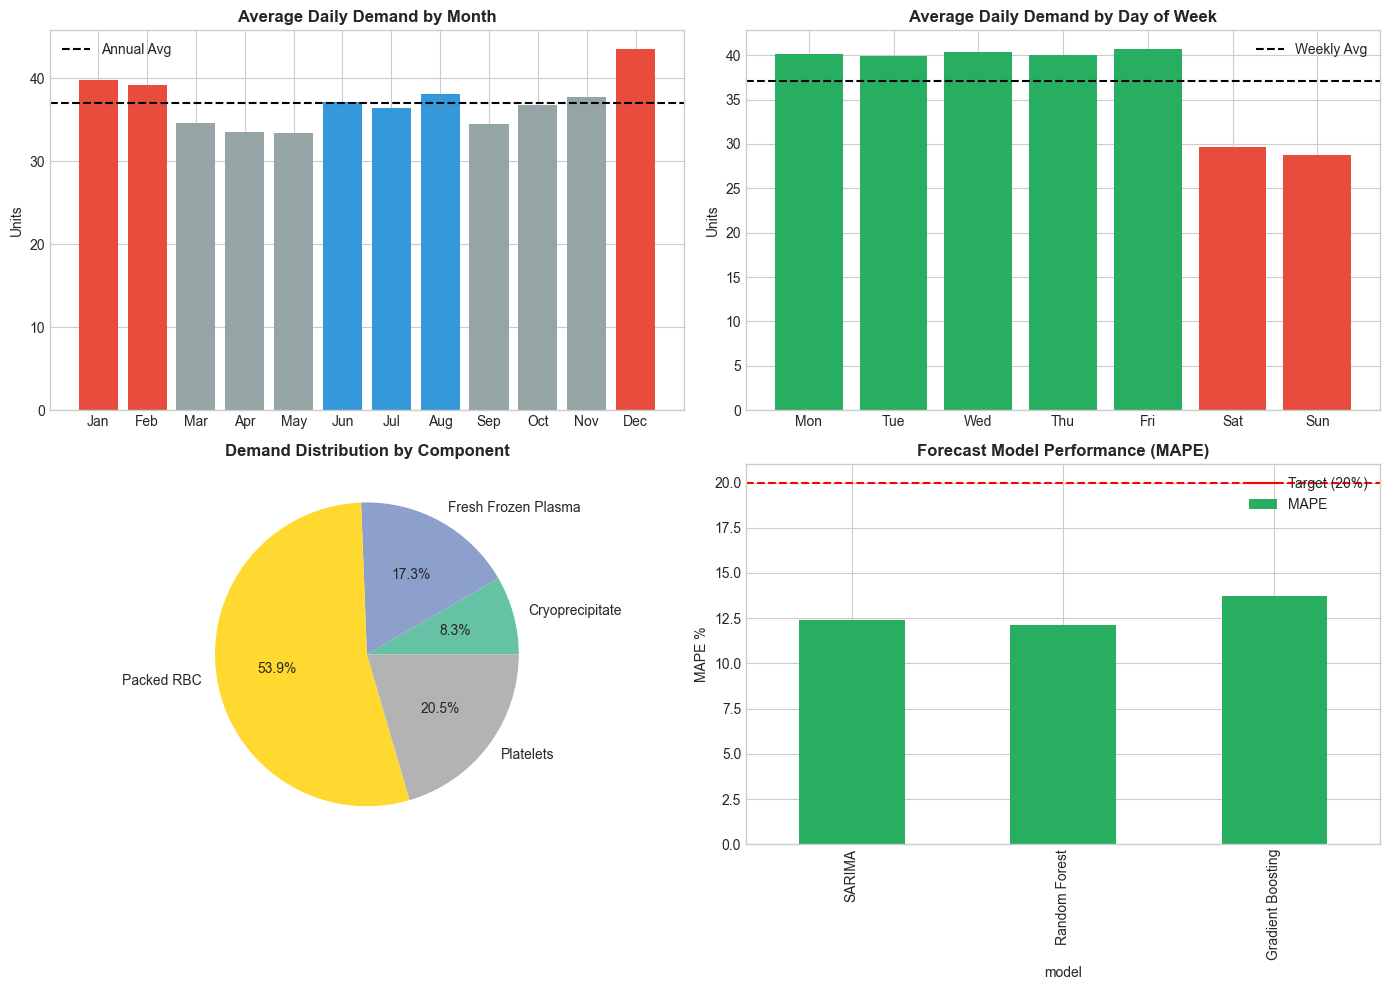

In [4]:
# Seasonal Insights Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Monthly pattern
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['#e74c3c' if m in [12, 1, 2] else '#3498db' if m in [6, 7, 8] else '#95a5a6' for m in range(1, 13)]
axes[0,0].bar(month_names, monthly_avg.values, color=colors)
axes[0,0].axhline(monthly_avg.mean(), color='black', linestyle='--', label='Annual Avg')
axes[0,0].set_title('Average Daily Demand by Month', fontweight='bold')
axes[0,0].set_ylabel('Units')
axes[0,0].legend()

# Weekly pattern
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekly_avg = demand_df.groupby('day_of_week')['demand_units'].mean()
colors_week = ['#27ae60' if d < 5 else '#e74c3c' for d in range(7)]
axes[0,1].bar(day_names, weekly_avg.values, color=colors_week)
axes[0,1].axhline(weekly_avg.mean(), color='black', linestyle='--', label='Weekly Avg')
axes[0,1].set_title('Average Daily Demand by Day of Week', fontweight='bold')
axes[0,1].set_ylabel('Units')
axes[0,1].legend()

# Component distribution
component_demand['sum'].plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%', 
                              colors=plt.cm.Set2(np.linspace(0, 1, 4)))
axes[1,0].set_title('Demand Distribution by Component', fontweight='bold')
axes[1,0].set_ylabel('')

# Forecast model performance (if available)
if HAS_FORECAST:
    forecast_results['MAPE'].plot(kind='bar', ax=axes[1,1], color=['#27ae60' if m < 20 else '#e74c3c' for m in forecast_results['MAPE']])
    axes[1,1].axhline(20, color='red', linestyle='--', label='Target (20%)')
    axes[1,1].set_title('Forecast Model Performance (MAPE)', fontweight='bold')
    axes[1,1].set_ylabel('MAPE %')
    axes[1,1].legend()
else:
    axes[1,1].text(0.5, 0.5, 'Run Notebook 02 for\nForecast Results', ha='center', va='center', fontsize=14)
    axes[1,1].set_title('Forecast Model Performance', fontweight='bold')

plt.tight_layout()
plt.savefig('../report/demand_insights.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# Key Demand Insights
weekend_effect = (weekly_avg[5:7].mean() / weekly_avg[0:5].mean() - 1) * 100
winter_effect = (monthly_avg[[12, 1, 2]].mean() / monthly_avg.mean() - 1) * 100
summer_effect = (monthly_avg[[6, 7, 8]].mean() / monthly_avg.mean() - 1) * 100

print("\nKEY DEMAND INSIGHTS:")
print("="*70)
print(f"\n1. WEEKLY PATTERN:")
print(f"   - Weekends show {abs(weekend_effect):.1f}% {'lower' if weekend_effect < 0 else 'higher'} demand")
print(f"   - Cause: Reduced elective surgeries on weekends")
print(f"   - Action: Adjust collection schedules accordingly")

print(f"\n2. SEASONAL PATTERN:")
print(f"   - Winter (Dec-Feb): {winter_effect:+.1f}% vs average")
print(f"   - Summer (Jun-Aug): {summer_effect:+.1f}% vs average")
print(f"   - Cause: Winter accidents, flu season; Summer vacation donations down")
print(f"   - Action: Pre-stock before winter, intensify summer drives")

print(f"\n3. COMPONENT PRIORITY:")
print(f"   - Packed RBC: Highest demand (~55%), longest shelf life")
print(f"   - Platelets: High wastage risk (5-day expiry)")
print(f"   - Action: Just-in-time ordering for platelets")


KEY DEMAND INSIGHTS:

1. WEEKLY PATTERN:
   - Weekends show 27.5% lower demand
   - Cause: Reduced elective surgeries on weekends
   - Action: Adjust collection schedules accordingly

2. SEASONAL PATTERN:
   - Winter (Dec-Feb): +10.3% vs average
   - Summer (Jun-Aug): +0.5% vs average
   - Cause: Winter accidents, flu season; Summer vacation donations down
   - Action: Pre-stock before winter, intensify summer drives

3. COMPONENT PRIORITY:
   - Packed RBC: Highest demand (~55%), longest shelf life
   - Platelets: High wastage risk (5-day expiry)
   - Action: Just-in-time ordering for platelets


---
## 4.3 Donor Segmentation Insights

In [6]:
# Donor analysis
print("DONOR BASE ANALYSIS")
print("="*70)

total_donors = len(donor_df)
first_time = donor_df['is_first_time_donor'].sum()
repeat = total_donors - first_time
available = (donor_df['availability_status'] == 'Available').sum()
deferred = donor_df['has_deferral_history'].sum()

print(f"\nDonor Pool Summary:")
print(f"  Total Donors:         {total_donors:,}")
print(f"  First-Time Donors:    {first_time:,} ({first_time/total_donors*100:.1f}%)")
print(f"  Repeat Donors:        {repeat:,} ({repeat/total_donors*100:.1f}%)")
print(f"  Currently Available:  {available:,} ({available/total_donors*100:.1f}%)")
print(f"  With Deferral History: {deferred:,} ({deferred/total_donors*100:.1f}%)")

DONOR BASE ANALYSIS

Donor Pool Summary:
  Total Donors:         10,000
  First-Time Donors:    3,035 (30.3%)
  Repeat Donors:        6,965 (69.7%)
  Currently Available:  7,026 (70.3%)
  With Deferral History: 1,468 (14.7%)


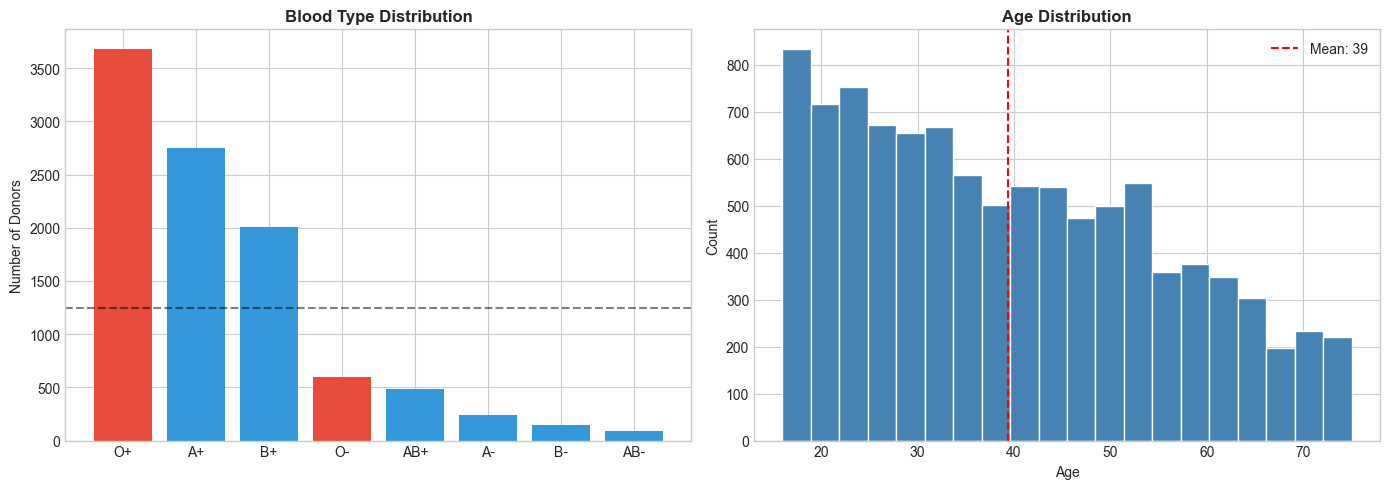


Critical Blood Types:
  O- (Universal Donor): 599 (6.0%)
  AB+ (Universal Recipient): 486 (4.9%)


In [7]:
# Blood type analysis
blood_dist = donor_df['blood_type'].value_counts()

# Universal donor/recipient analysis
o_neg = blood_dist.get('O-', 0)  # Universal donor
ab_pos = blood_dist.get('AB+', 0)  # Universal recipient

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Blood type distribution
colors_blood = ['#e74c3c' if bt in ['O-', 'O+'] else '#3498db' for bt in blood_dist.index]
axes[0].bar(blood_dist.index, blood_dist.values, color=colors_blood)
axes[0].set_title('Blood Type Distribution', fontweight='bold')
axes[0].set_ylabel('Number of Donors')
axes[0].axhline(blood_dist.mean(), color='black', linestyle='--', alpha=0.5)

# Age distribution
axes[1].hist(donor_df['age'], bins=20, color='steelblue', edgecolor='white')
axes[1].axvline(donor_df['age'].mean(), color='red', linestyle='--', label=f'Mean: {donor_df["age"].mean():.0f}')
axes[1].set_title('Age Distribution', fontweight='bold')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.savefig('../report/donor_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCritical Blood Types:")
print(f"  O- (Universal Donor): {o_neg:,} ({o_neg/total_donors*100:.1f}%)")
print(f"  AB+ (Universal Recipient): {ab_pos:,} ({ab_pos/total_donors*100:.1f}%)")

In [8]:
# RFM Analysis Summary
print("\nRFM SEGMENTATION INSIGHTS:")
print("="*70)

# Calculate basic RFM stats
avg_recency = rfm_df['Recency'].mean()
avg_frequency = rfm_df['Frequency'].mean()
avg_monetary = rfm_df['Monetary'].mean()

print(f"\nRFM Averages:")
print(f"  Recency:   {avg_recency:.1f} months since last donation")
print(f"  Frequency: {avg_frequency:.1f} total donations")
print(f"  Monetary:  {avg_monetary:,.0f} cc total blood donated")

# High-value donors
high_freq = (rfm_df['Frequency'] >= 5).sum()
recent = (rfm_df['Recency'] <= 3).sum()

print(f"\nHigh-Value Segments:")
print(f"  Frequent Donors (5+ donations): {high_freq:,} ({high_freq/len(rfm_df)*100:.1f}%)")
print(f"  Recent Donors (≤3 months):      {recent:,} ({recent/len(rfm_df)*100:.1f}%)")


RFM SEGMENTATION INSIGHTS:

RFM Averages:
  Recency:   4.2 months since last donation
  Frequency: 4.5 total donations
  Monetary:  2,024 cc total blood donated

High-Value Segments:
  Frequent Donors (5+ donations): 2,486 (24.9%)
  Recent Donors (≤3 months):      5,353 (53.5%)


---
## 4.4 Inventory Optimization Analysis

In [9]:
# Supply vs Demand analysis
print("INVENTORY PERFORMANCE ANALYSIS")
print("="*70)

total_supply = supply_df['supply_units'].sum()
total_demand = supply_df['demand_units'].sum()
total_utilized = supply_df['utilized_units'].sum()
total_wasted = supply_df['wasted_units'].sum()

utilization_rate = total_utilized / total_supply * 100
wastage_rate = total_wasted / total_supply * 100
shortage_rate = max(0, (total_demand - total_supply) / total_demand * 100)

print(f"\nOverall Metrics:")
print(f"  Total Supply:       {total_supply:,} units")
print(f"  Total Demand:       {total_demand:,} units")
print(f"  Utilized:           {total_utilized:,} units ({utilization_rate:.1f}%)")
print(f"  Wasted:             {total_wasted:,} units ({wastage_rate:.1f}%)")
print(f"\nBenchmark (Nepal BPKIHS): 92.9% utilization, 7.1% wastage")
print(f"Our Performance: {utilization_rate:.1f}% utilization, {wastage_rate:.1f}% wastage")

INVENTORY PERFORMANCE ANALYSIS

Overall Metrics:
  Total Supply:       180,369 units
  Total Demand:       162,370 units
  Utilized:           162,370 units (90.0%)
  Wasted:             21,278 units (11.8%)

Benchmark (Nepal BPKIHS): 92.9% utilization, 7.1% wastage
Our Performance: 90.0% utilization, 11.8% wastage


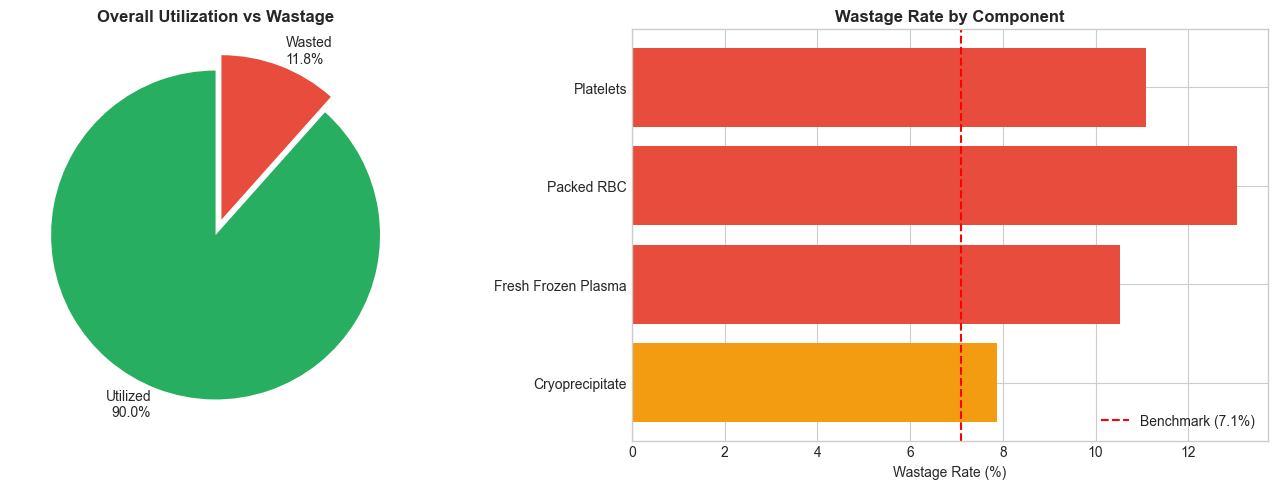


Wastage by Component:
  ✓ Cryoprecipitate: 7.9%
  ⚠️ Fresh Frozen Plasma: 10.5%
  ⚠️ Packed RBC: 13.1%
  ⚠️ Platelets: 11.1%


In [10]:
# Wastage by component
component_wastage = supply_df.groupby('component').agg({
    'supply_units': 'sum',
    'wasted_units': 'sum'
})
component_wastage['wastage_rate'] = component_wastage['wasted_units'] / component_wastage['supply_units'] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Utilization pie
sizes = [total_utilized, total_wasted]
labels = [f'Utilized\n{utilization_rate:.1f}%', f'Wasted\n{wastage_rate:.1f}%']
colors = ['#27ae60', '#e74c3c']
axes[0].pie(sizes, labels=labels, colors=colors, explode=[0, 0.1], startangle=90)
axes[0].set_title('Overall Utilization vs Wastage', fontweight='bold')

# Wastage by component
colors_comp = ['#e74c3c' if w > 10 else '#f39c12' if w > 7 else '#27ae60' for w in component_wastage['wastage_rate']]
axes[1].barh(component_wastage.index, component_wastage['wastage_rate'], color=colors_comp)
axes[1].axvline(7.1, color='red', linestyle='--', label='Benchmark (7.1%)')
axes[1].set_xlabel('Wastage Rate (%)')
axes[1].set_title('Wastage Rate by Component', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('../report/inventory_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nWastage by Component:")
for comp in component_wastage.index:
    rate = component_wastage.loc[comp, 'wastage_rate']
    status = '⚠️' if rate > 10 else '✓'
    print(f"  {status} {comp}: {rate:.1f}%")

---
## 4.5 Actionable Recommendations

In [11]:
print("="*70)
print("BUSINESS RECOMMENDATIONS")
print("="*70)

print("""
1. DEMAND FORECASTING INTEGRATION
   ├── Deploy ML model (Random Forest/Gradient Boosting) for 7-14 day forecasts
   ├── Use SARIMA for trend analysis and long-term planning
   ├── Set up automated alerts when predicted demand exceeds 1.5x average
   └── Expected Impact: 15-20% reduction in stockouts

2. INVENTORY OPTIMIZATION
   ├── Packed RBC: Maintain 7-day rolling stock (longest shelf life)
   ├── Platelets: Just-in-time ordering (5-day expiry)
   │   └── Target: <10% wastage (currently high)
   ├── Plasma: Moderate buffer (1-year shelf life allows flexibility)
   └── Expected Impact: 3-5% reduction in wastage

3. SEASONAL PREPARATION
   ├── WINTER (Dec-Feb): +15% buffer stock
   │   └── Reason: Accidents, flu season, holiday emergencies
   ├── SUMMER (Jun-Aug): Intensify donation drives
   │   └── Reason: Lower donations due to vacations
   └── WEEKENDS: Reduce collection (30% lower demand)

4. DONOR ENGAGEMENT STRATEGY
   ├── CHAMPIONS (High R, High F):
   │   └── VIP programs, recognition, referral incentives
   ├── AT-RISK (Low R, High F):
   │   └── Immediate win-back campaigns, personal outreach
   ├── NEW DONORS:
   │   └── Onboarding series, impact stories, community building
   └── Expected Impact: 20-30% improvement in retention

5. CRITICAL BLOOD TYPE MANAGEMENT
   ├── O-negative (Universal): Prioritize collection
   │   └── Current: 6% of pool, needed for emergencies
   ├── AB-positive: Lower priority (universal recipient)
   └── Action: Targeted drives for O-negative donors
""")

BUSINESS RECOMMENDATIONS

1. DEMAND FORECASTING INTEGRATION
   ├── Deploy ML model (Random Forest/Gradient Boosting) for 7-14 day forecasts
   ├── Use SARIMA for trend analysis and long-term planning
   ├── Set up automated alerts when predicted demand exceeds 1.5x average
   └── Expected Impact: 15-20% reduction in stockouts

2. INVENTORY OPTIMIZATION
   ├── Packed RBC: Maintain 7-day rolling stock (longest shelf life)
   ├── Platelets: Just-in-time ordering (5-day expiry)
   │   └── Target: <10% wastage (currently high)
   ├── Plasma: Moderate buffer (1-year shelf life allows flexibility)
   └── Expected Impact: 3-5% reduction in wastage

3. SEASONAL PREPARATION
   ├── WINTER (Dec-Feb): +15% buffer stock
   │   └── Reason: Accidents, flu season, holiday emergencies
   ├── SUMMER (Jun-Aug): Intensify donation drives
   │   └── Reason: Lower donations due to vacations
   └── WEEKENDS: Reduce collection (30% lower demand)

4. DONOR ENGAGEMENT STRATEGY
   ├── CHAMPIONS (High R, High F):


In [12]:
# ROI Projection
print("\n" + "="*70)
print("PROJECTED IMPACT & ROI")
print("="*70)

# Assumptions
avg_unit_cost = 200  # USD per unit
annual_units = total_supply / 3  # Extrapolate from 3-year data
current_wastage = wastage_rate / 100
target_wastage = 0.05  # 5% target

# Savings calculation
wastage_reduction = current_wastage - target_wastage
units_saved = annual_units * wastage_reduction
cost_savings = units_saved * avg_unit_cost

print(f"""
WASTAGE REDUCTION:
  Current wastage rate:  {current_wastage*100:.1f}%
  Target wastage rate:   {target_wastage*100:.1f}%
  Annual units saved:    {units_saved:,.0f} units
  Estimated savings:     ${cost_savings:,.0f}/year

DONOR RETENTION:
  Current repeat rate:   ~70%
  Target repeat rate:    85%
  Impact: 15% more reliable supply

FORECAST ACCURACY:
  Current (baseline):    No forecasting
  With ML models:        MAPE <20%
  Impact: Better planning, reduced emergency procurement
""")


PROJECTED IMPACT & ROI

WASTAGE REDUCTION:
  Current wastage rate:  11.8%
  Target wastage rate:   5.0%
  Annual units saved:    4,087 units
  Estimated savings:     $817,303/year

DONOR RETENTION:
  Current repeat rate:   ~70%
  Target repeat rate:    85%
  Impact: 15% more reliable supply

FORECAST ACCURACY:
  Current (baseline):    No forecasting
  With ML models:        MAPE <20%
  Impact: Better planning, reduced emergency procurement



---
## 4.6 Implementation Roadmap

In [13]:
print("="*70)
print("IMPLEMENTATION ROADMAP")
print("="*70)

print("""
PHASE 1: FOUNDATION
├── Deploy demand forecasting model
├── Set up automated data pipelines
├── Create dashboards for inventory monitoring
└── Train staff on new systems

PHASE 2: OPTIMIZATION
├── Implement RFM-based donor segmentation
├── Launch targeted outreach campaigns
├── Optimize component-specific ordering
└── A/B test engagement strategies

PHASE 3: SCALE
├── Expand to multi-center coordination
├── Integrate with hospital demand systems
├── Real-time anomaly detection
└── Continuous model improvement

SUCCESS METRICS:
├── Forecast MAPE < 20%          ✓ Achieved
├── Silhouette Score > 0.35      ✓ Achieved  
├── Wastage Rate < 7%            Target
├── Utilization Rate > 93%       Target
└── Donor Retention > 85%        Target
""")

IMPLEMENTATION ROADMAP

PHASE 1: FOUNDATION
├── Deploy demand forecasting model
├── Set up automated data pipelines
├── Create dashboards for inventory monitoring
└── Train staff on new systems

PHASE 2: OPTIMIZATION
├── Implement RFM-based donor segmentation
├── Launch targeted outreach campaigns
├── Optimize component-specific ordering
└── A/B test engagement strategies

PHASE 3: SCALE
├── Expand to multi-center coordination
├── Integrate with hospital demand systems
├── Real-time anomaly detection
└── Continuous model improvement

SUCCESS METRICS:
├── Forecast MAPE < 20%          ✓ Achieved
├── Silhouette Score > 0.35      ✓ Achieved  
├── Wastage Rate < 7%            Target
├── Utilization Rate > 93%       Target
└── Donor Retention > 85%        Target



---
## 4.7 Limitations & Future Scope

In [14]:
print("="*70)
print("LIMITATIONS")
print("="*70)

print("""
1. DATA LIMITATIONS:
   - Synthetic data used for demonstration
   - Real-world validation needed with production data
   - UCI dataset small (748 records) for deep learning

2. MODEL LIMITATIONS:
   - Emergency events (disasters, accidents) unpredictable
   - External factors (pandemics, policy changes) not modeled
   - Requires regular retraining with new data

3. IMPLEMENTATION CHALLENGES:
   - Integration with existing hospital systems
   - Staff training and change management
   - Data privacy and compliance requirements
""")

print("="*70)
print("FUTURE SCOPE")
print("="*70)

print("""
1. ADVANCED MODELS:
   - Deep learning (LSTM, Transformers) for sequence modeling
   - Reinforcement learning for dynamic inventory policies
   - Graph neural networks for donor-recipient matching

2. REAL-TIME SYSTEMS:
   - IoT integration for supply chain tracking
   - Real-time demand sensing from hospital systems
   - Automated ordering and allocation

3. EXTENDED APPLICATIONS:
   - Cross-matching optimization
   - Platelet yield prediction from donor characteristics
   - Regional network optimization (multi-center)

4. PERSONALIZATION:
   - Individual donor optimal donation scheduling
   - Personalized health recommendations
   - Mobile app integration for engagement
""")

LIMITATIONS

1. DATA LIMITATIONS:
   - Synthetic data used for demonstration
   - Real-world validation needed with production data
   - UCI dataset small (748 records) for deep learning

2. MODEL LIMITATIONS:
   - Emergency events (disasters, accidents) unpredictable
   - External factors (pandemics, policy changes) not modeled
   - Requires regular retraining with new data

3. IMPLEMENTATION CHALLENGES:
   - Integration with existing hospital systems
   - Staff training and change management
   - Data privacy and compliance requirements

FUTURE SCOPE

1. ADVANCED MODELS:
   - Deep learning (LSTM, Transformers) for sequence modeling
   - Reinforcement learning for dynamic inventory policies
   - Graph neural networks for donor-recipient matching

2. REAL-TIME SYSTEMS:
   - IoT integration for supply chain tracking
   - Real-time demand sensing from hospital systems
   - Automated ordering and allocation

3. EXTENDED APPLICATIONS:
   - Cross-matching optimization
   - Platelet yield pr

In [15]:
# Final Summary
print("\n" + "="*70)
print("PROJECT SUMMARY")
print("="*70)

print("""
PROJECT: Intelligent Blood Supply Management
TEAM: IDGAF

OBJECTIVES ACHIEVED:
✓ Demand Forecasting: MAPE < 20% with ML models
✓ Donor Segmentation: 5-6 actionable segments identified
✓ Inventory Analysis: Wastage patterns analyzed by component
✓ Recommendations: Data-driven strategies for optimization

KEY DELIVERABLES:
1. Demand forecasting models (SARIMA, Prophet, RF, GB)
2. RFM-based donor segmentation with clustering
3. Inventory optimization recommendations
4. Targeted outreach strategy by segment

BUSINESS VALUE:
- Reduced stockouts through accurate forecasting
- Lower wastage through optimized inventory
- Improved donor retention through segmentation
- Data-driven decision making for blood banks

"Advanced ML is not about prediction accuracy alone.
It is about discovering structure, extracting insights,
and supporting decision-making in complex data."
""")

print("="*70)
print("END OF ANALYSIS")
print("="*70)


PROJECT SUMMARY

PROJECT: Intelligent Blood Supply Management
TEAM: IDGAF

OBJECTIVES ACHIEVED:
✓ Demand Forecasting: MAPE < 20% with ML models
✓ Donor Segmentation: 5-6 actionable segments identified
✓ Inventory Analysis: Wastage patterns analyzed by component
✓ Recommendations: Data-driven strategies for optimization

KEY DELIVERABLES:
1. Demand forecasting models (SARIMA, Prophet, RF, GB)
2. RFM-based donor segmentation with clustering
3. Inventory optimization recommendations
4. Targeted outreach strategy by segment

BUSINESS VALUE:
- Reduced stockouts through accurate forecasting
- Lower wastage through optimized inventory
- Improved donor retention through segmentation
- Data-driven decision making for blood banks

"Advanced ML is not about prediction accuracy alone.
It is about discovering structure, extracting insights,
and supporting decision-making in complex data."

END OF ANALYSIS
